<a href="https://colab.research.google.com/github/nidjosep/student-feedback-analysis/blob/master/Project_module_emotion2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import ssl
import seaborn as sns
from google.colab import drive
from keras.layers import Bidirectional, GlobalMaxPool1D
import json

In [3]:
drive.mount('/content/drive', force_remount=True)

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Teaching/TME_6015/Project/data.csv')

Mounted at /content/drive


In [5]:


try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download NLTK stopwords
nltk.download()
nltk.download('stopwords')
# Load stop words
stop_words = set(stopwords.words('english'))

# Function to remove stop words
def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# df = df.head(4000)

df = df[df['Message'].astype(str).str.strip() != '']
df['Message'] = df['Message'].astype(str)

df['Message'] = df['Message'].apply(remove_stop_words)

# Split the data into training and testing sets
train_reviews, test_reviews, train_labels, test_labels = train_test_split(
    df['Message'], df['Feeling'] , test_size=0.2, random_state=42)

# Create a label encoder object
label_encoder = LabelEncoder()

# Fit the label encoder to your labels and transform them to integers
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000)  # Adjust num_words as needed
tokenizer.fit_on_texts(train_reviews)
X_train_seq = tokenizer.texts_to_sequences(train_reviews)
X_test_seq = tokenizer.texts_to_sequences(test_reviews)
X_train_pad = pad_sequences(X_train_seq, maxlen=150)  # Adjust maxlen as needed
X_test_pad = pad_sequences(X_test_seq, maxlen=150)

# tf.keras.layers.Bidirectional(
#     layer, merge_mode="concat", weights=None, backward_layer=None, **kwargs
# )
# Building the LSTM model with cuDNN optimization
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=150))
# model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(100)))
# model.add(Dropout(0.2))
model.add(Dense(128, activation='elu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(6, activation='sigmoid', dtype='float32'))  # Ensure output layer uses float32


# Compile the model with adjusted learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, train_labels,batch_size=64, epochs=3,
                    validation_data=(X_test_pad, test_labels))



print(history.history['accuracy'])
print(history.history['loss'])


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Epoch 1/3
126/126 [==============================] - 108s 821ms/step - loss: 0.7536 - accuracy: 0.7550 - val_loss: 0.3627 - val_accuracy: 0.8947
Epoch 2/3
126/126 [==============================] - 92s 729ms/step - loss: 0.2154 - accuracy: 0.9360 - val_loss: 0.4250 - val_accuracy: 0.8882
Epoch 3/3
126/126 [==============================] - 89s 711ms/step - loss: 0.1274 - accuracy: 0.9604 - val_loss: 0.4149 - val_accuracy: 0.8942
[0.7549924850463867, 0.9359710216522217, 0.9604343771934509]
[0.753564715385437, 0.21541590988636017, 0.1274406760931015]


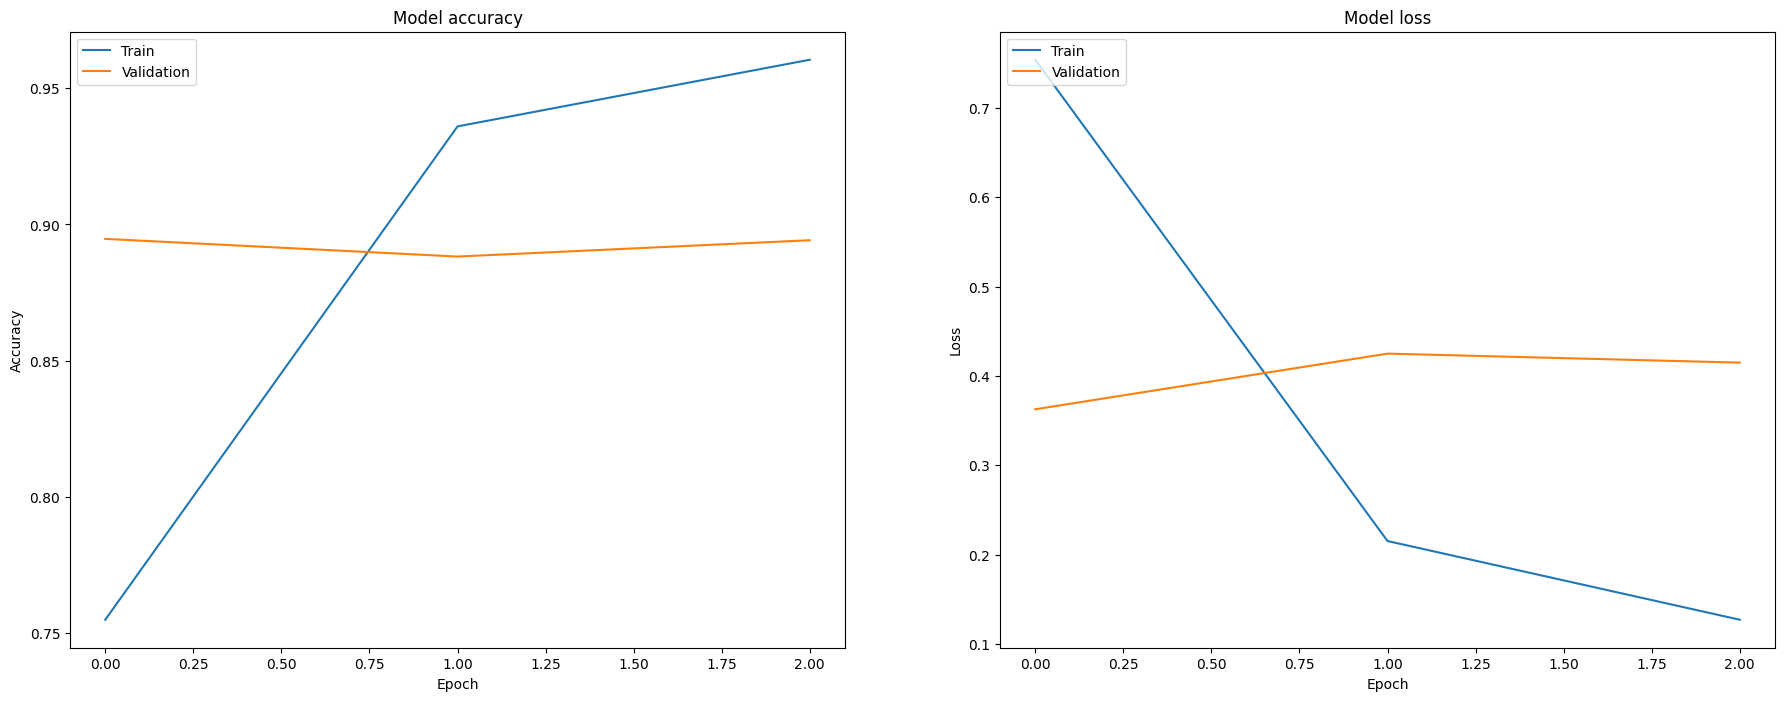

In [6]:

# Plot training & validation accuracy values
plt.figure(figsize=(22, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


63/63 [==============================] - 7s 93ms/step


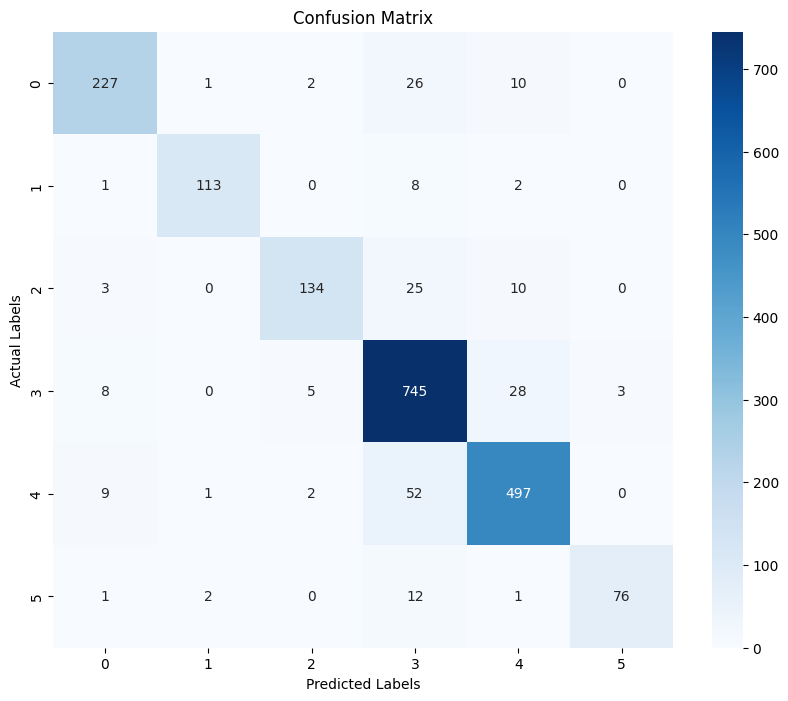

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       266
           1       0.97      0.91      0.94       124
           2       0.94      0.78      0.85       172
           3       0.86      0.94      0.90       789
           4       0.91      0.89      0.90       561
           5       0.96      0.83      0.89        92

    accuracy                           0.89      2004
   macro avg       0.92      0.87      0.89      2004
weighted avg       0.90      0.89      0.89      2004

Accuracy: 0.8942115768463074


In [7]:
# Evaluate the model
model.evaluate(X_test_pad, test_labels)

# Predict classes
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

 # Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Print the classification report
print(classification_report(test_labels, y_pred_classes))

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, y_pred_classes)
print(f"Accuracy: {accuracy}")


In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming you have the tokenizer used during training
# tokenizer = ... (Load or create the tokenizer used during training)

# Function to read JSON file
def read_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Function to write JSON file
def write_json(data, file_path):
    with open(file_path, 'w') as file:
        json.dump(data, file)


def remove_stop_words_from_list(texts):
    processed_texts = []
    for text in texts:
        processed_text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
        processed_texts.append(processed_text)
    return processed_texts

# Read test data
test_data_dict = read_json('/content/drive/MyDrive/Teaching/TME_6015/Project/test_data.json')  # Make sure this path is correct

# Extract messages from the test data
test_messages = list(test_data_dict.values())
test_messages = remove_stop_words_from_list(test_messages)
# Preprocess test data
X_test_seq = tokenizer.texts_to_sequences(test_messages)
X_test_pad = pad_sequences(X_test_seq, maxlen=150)  # Adjust maxlen if needed

# Make predictions
predictions = model.predict(X_test_pad)
predicted_labels = label_encoder.inverse_transform([np.argmax(p) for p in predictions])

# Prepare data for JSON output
output_predictions = {id: label for id, label in zip(test_data_dict.keys(), predicted_labels)}
print(output_predictions)
# Write predictions to JSON
write_json(output_predictions, '/content/drive/MyDrive/Teaching/TME_6015/Project/predictions.json')

print("Predictions saved to predictions.json")



1/1 [==============================] - 0s 97ms/step
{'1': 'happy', '2': 'happy', '3': 'happy', '4': 'fear', '5': 'happy', '6': 'fear', '7': 'fear', '8': 'happy', '9': 'happy', '10': 'sad', '11': 'sad'}
Predictions saved to predictions.json
